Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Textual Analysis

Information on the Python Packages used:  
http://docs.python.org/library/re.html  
http://www.pythonware.com/library/pil/handbook/index.htm  
http://nltk.org/  
https://networkx.github.io/  
https://github.com/grangier/python-goose  
https://pypi.python.org/pypi/Topics  
http://radimrehurek.com/gensim/  
http://docs.python-requests.org/en/latest/  

In [89]:
import os
import time
import codecs
import string
import urllib2
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import networkx as nx
import re
import re2
import gensim
from collections import OrderedDict, Counter
from bs4 import BeautifulSoup
from goose import Goose
from IPython.core.display import Image
from Topics.onlineldavb import onlineldavb
from Topics.visualization.wordcloud import make_wordcloud
from Topics.visualization.topiccloud import GenCloud
from Topics.visualization.printtopics import list_topics
%matplotlib inline

Specifying the path to the files

In [90]:
datapath = '/home/rsouza/Dropbox/Renato/ModMinDados/Git/datasets/'
outputs = '/home/rsouza/Dropbox/Renato/ModMinDados/outputs/'
oplexicon = 'oplexicon_v3.0/lexico_v3.0.txt'

#### Basic Polarizing Functions for Sentiment Analysis

Loading the polarized lexycom file - OpLexicon (BR)

In [91]:
df_o = pd.read_csv(os.path.join(datapath,oplexicon), header=None, encoding='utf-8', usecols=[0,2], names=[u'palavra',u'polaridade'])
df_o.drop_duplicates(subset=[u'palavra'], take_last=False, inplace=True)
df_o = df_o.set_index(u'palavra')
print(u'Corpus com {} palavras polarizadas'.format(len(df_o)))

Corpus com 32119 palavras polarizadas


In [92]:
def polariza_texto(texto, df1):
    polaridades = []
    ausentes = []
    l_palavras = texto.split()
    for palavra in l_palavras:
        p = palavra.lower().strip()
        if p in df1.index:
            polaridades.append(df1.polaridade[p])
        else:
            ausentes.append(p)
    num_pal = len(l_palavras)
    num_pol = len(polaridades)
    razao_pol = num_pol/float(num_pal) if num_pal else 0.0
    polaridade = sum(polaridades)/float(num_pol) if num_pol else 0.0
    #print('Foram polarizadas {} palavras de um total de {} ({:.2%})'.format(num_pol, num_pal, razao_pol))
    #print('A polaridade mensurada do texto é de {:.3}'.format(polaridade))
    return polaridade, ausentes

In [93]:
def polariza_counter(dicionario, df1):
    polaridades = []
    fator_div = 0
    ausentes = []
    for palavra, frequencia in dicionario.iteritems():
        p = palavra.lower().strip()
        if p in df1.index:
            polaridades.append(df1.polaridade[p] * frequencia)
            fator_div += frequencia
        else:
            ausentes.append((palavra,frequencia))
    num_pal = len(dicionario)
    num_pol = len(polaridades)
    razao_pol = num_pol/float(num_pal) if num_pal else 0.0
    polaridade = sum(polaridades)/float(fator_div)
    print('Foram polarizadas {} palavras de um total de {} ({:.2%})'.format(num_pol, num_pal, razao_pol))
    print('A polaridade mensurada do texto é de {:.3}'.format(polaridade))
    return polaridade, ausentes

#### Capturing some html pages from a newspaper:

In [146]:
url_uol = u'http://busca.uol.com.br/uol/?ref=homeuol&ad=on&q={}&start={}'
query = u'Corrupcao'
results_pages_to_capture = 5

In [147]:
rawpages = ''
for i in range(0,10*(results_pages_to_capture),10):
    try:
        print(u'Page {} captured'.format(i)) 
        request = url_uol.format(query,str(i))
        rawpages = rawpages + urllib2.urlopen(request).read()
    except Exception as inst:
        print type(inst)

Page 0 captured
Page 10 captured
Page 20 captured
Page 30 captured
Page 40 captured


In [148]:
links = re.findall(r'(https?://\S+)', rawpages)
links = [l.strip('"') for l in links]
links = [l.split('"')[0] for l in links]
links = [l for l in links if l.endswith('shtml')]
links = sorted(list(set(links)))

print('{} extracted links'.format(len(links)))
for link in links:
    print link

25 extracted links
http://www1.folha.uol.com.br/colunas/carlosheitorcony/2014/11/1551851-o-dna-da-corrupcao.shtml
http://www1.folha.uol.com.br/colunas/demetriomagnoli/2014/11/1551703-500-anos-de-corrupcao.shtml
http://www1.folha.uol.com.br/colunas/luizfelipeponde/2014/10/1527816-politica-corrupcao-e-pizza.shtml
http://www1.folha.uol.com.br/colunas/raquelrolnik/2014/10/1535070-a-falacia-da-corrupcao.shtml
http://www1.folha.uol.com.br/cotidiano/2013/06/1299344-corrupcao-e-principal-motivacao-de-manifestantes-em-sp-diz-datafolha.shtml
http://www1.folha.uol.com.br/cotidiano/2015/04/1612495-ilha-da-indonesia-tornou-se-paraiso-da-corrupcao-dizem-turistas-e-moradores.shtml
http://www1.folha.uol.com.br/fsp/ilustrada/216615-contra-a-corrupcao.shtml
http://www1.folha.uol.com.br/mercado/2015/01/1581560-apos-dois-adiamentos-petrobras-divulga-balanco-sem-baixas-por-corrupcao.shtml
http://www1.folha.uol.com.br/mercado/2015/01/1581676-para-petrobras-corrupcao-comecou-em-2004-e-parou-com-saida-de-dire

In [149]:
def goose_extract(htmltxt):
    g = Goose({'use_meta_language': False, 'target_language':'pt'})
    article = g.extract(url=htmltxt)
    title = article.title
    meta = article.meta_description
    txt = article.cleaned_text
    fig = article.top_image.src
    return txt, title, meta, fig

In [150]:
deupau = []
for link in links:
    try:
        print(link)
        rawpage = goose_extract(link)[0]
        if rawpage:
            f = codecs.open(os.path.join(outputs,'html_out','{}'.format(link[29:].replace('/','_'))), mode='w', encoding='utf-8')
            f.write(rawpage)
            f.close()
            print('Sucesso!\n')
            time.sleep(1)
    except Exception as inst:
        print(inst)
        print(type(inst))
        deupau.append(link)
        print('Insucesso!\n')
        time.sleep(0.3)

http://www1.folha.uol.com.br/colunas/carlosheitorcony/2014/11/1551851-o-dna-da-corrupcao.shtml
Sucesso!

http://www1.folha.uol.com.br/colunas/demetriomagnoli/2014/11/1551703-500-anos-de-corrupcao.shtml
Sucesso!

http://www1.folha.uol.com.br/colunas/luizfelipeponde/2014/10/1527816-politica-corrupcao-e-pizza.shtml
Sucesso!

http://www1.folha.uol.com.br/colunas/raquelrolnik/2014/10/1535070-a-falacia-da-corrupcao.shtml
Sucesso!

http://www1.folha.uol.com.br/cotidiano/2013/06/1299344-corrupcao-e-principal-motivacao-de-manifestantes-em-sp-diz-datafolha.shtml
Sucesso!

http://www1.folha.uol.com.br/cotidiano/2015/04/1612495-ilha-da-indonesia-tornou-se-paraiso-da-corrupcao-dizem-turistas-e-moradores.shtml
Sucesso!

http://www1.folha.uol.com.br/fsp/ilustrada/216615-contra-a-corrupcao.shtml
Sucesso!

http://www1.folha.uol.com.br/mercado/2015/01/1581560-apos-dois-adiamentos-petrobras-divulga-balanco-sem-baixas-por-corrupcao.shtml
Sucesso!

http://www1.folha.uol.com.br/mercado/2015/01/1581676-para-

In [151]:
for biziu in deupau:
    print biziu

Examinando os arquivos e pastas:

In [152]:
corpuspath = os.path.join(outputs,'html_out')
onlydirs = [f for f in os.listdir(corpuspath) if os.path.isdir(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlyfiles = [f for f in os.listdir(corpuspath) if os.path.isfile(os.path.join(corpuspath,f)) and not f.startswith('.')]
onlydirs.sort()

print 'Files in the folder:'
for i, w in enumerate(onlyfiles[0:]):
    print i+1, '--' ,w

Files in the folder:
1 -- colunas_carlosheitorcony_2014_11_1551851-o-dna-da-corrupcao.shtml
2 -- poder_2014_10_1533081-a-evangelicos-aecio-promete-combate-a-corrupcao-e-parceria-com-igrejas.shtml
3 -- poder_2015_03_1605688-pacote-do-mpf-quer-aumentar-pena-e-tornar-corrupcao-crime-hediondo.shtml
4 -- colunas_luizfelipeponde_2014_10_1527816-politica-corrupcao-e-pizza.shtml
5 -- poder_2015_04_1615756-irritacao-com-corrupcao-foi-motivacao-para-maioria.shtml
6 -- fsp_ilustrada_216615-contra-a-corrupcao.shtml
7 -- poder_2015_03_1603638-a-corrupcao-e-uma-senhora-idosa-diz-dilma-apos-os-protestos.shtml
8 -- poder_2013_06_1301820-senado-aprova-projeto-que-torna-corrupcao-crime-hediondo.shtml
9 -- mercado_2015_01_1581676-para-petrobras-corrupcao-comecou-em-2004-e-parou-com-saida-de-diretor.shtml
10 -- poder_2015_01_1575179-procuradoria-diz-nao-haver-provas-de-que-corrupcao-na-petrobras-acabou.shtml
11 -- poder_2015_01_1580939-petrobras-deve-divulgar-perdas-com-corrupcao.shtml
12 -- poder_2015_02

Carregando os corpora:

In [153]:
raw_texts = ''
list_raw_texts = []
for filename in onlyfiles:
    page_txt = codecs.open(os.path.join(corpuspath,filename), encoding='utf-8').read()
    raw_texts += u'\n'+ page_txt.lower()
    list_raw_texts.append(page_txt)

Ocorrências de determinada expressão no corpus

In [154]:
#expressao = u'nova_classe_média'.lower()
#expressao = u'Marcelo Néri'.lower()
expressao = u'Brasil'.lower()
#expressao = u'índice'.lower()
#expressao = u'Instituto de Pesquisa'.lower() #muitas grafias diferentes para o Ipea
#expressao = u'Ipea'.lower()
#expressao = u'porta dos fundos'.lower()

In [155]:
pos = 0 
positions = []
while pos != -1:
    position = raw_texts.find(expressao,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print(u'A expressão buscada ocorre {} vezes'.format(len(positions)))

A expressão buscada ocorre 36 vezes


In [156]:
for position in positions: #[0:10]:
    print raw_texts[position - 200:position + 200].strip()


mo inimiga preferencial. ela não acabou com o brasil, mas fez o que pôde. policarpo quaresma e macunaíma deixaram duas advertências históricas: derrotou o personagem de lima barreto que acreditava no brasil e serviu de mantra para mário de andrade lançar seu famoso anátema, "pouca saúde e muita saúva os males do brasil são".

a saúva foi para o banco dos reservas (pode entrar em campo a qualquer h
duas advertências históricas: derrotou o personagem de lima barreto que acreditava no brasil e serviu de mantra para mário de andrade lançar seu famoso anátema, "pouca saúde e muita saúva os males do brasil são".

a saúva foi para o banco dos reservas (pode entrar em campo a qualquer hora), mas a titular da posição, muito mais maléfica do que a saúva, é a corrupção que faz parte do nosso dna. bast
blicas.

participaram do encontro, em uma casa de eventos na região central de são paulo, cerca de 300 lideranças religiosas, entre representantes da cgadb (convenção geral das assembleias de deus 

Um passo opcional - retirar as stopwords que podem interferir nas análises

In [157]:
ignore_words = [w for w in nltk.corpus.stopwords.words('portuguese')]
#ignore_words.extend([s.decode('utf-8') for s in string.punctuation])
ignore_words.extend([u' ', u'', u'é', u'r',u'c',u'ainda',u'vai',u'ser',u'globo',u'sobre',u'nesta',u'\u2013',u'\u2014', u'pode',
                     u'ter', u'disse'])
ignore_expressions = [u'Copyright © 2013', u'Copyright © 2014',u'Todos os direitos reservados', 
                      u'Agência Estado', u'Jornal O Globo', u'Folha de S.Paulo', 'Globo Digital', u'SEGUNDO CADERNO',
                      u'Noblat', u'Agamenon Mendes Pedreira', u'Agamenon', u'Merval Pereira', u'Merval', u'Amaury de Souza',
                      u'Boa Viagem', u'v\xeddeos pol\xedticos', u'Esta\xe7\xe3o Jazz e Tal', u'a r\xe1dio do blog',
                      u'Siga o', u'Leia a', u'Ou\xe7a a', u'Curta a P\xe1gina', u'Visite a p\xe1gina', u'no Twitter','no Facebook', u'Blog do', 
                      u'Tradu\xe7\xe3o', u'mat&eacute;ria na &iacute;ntegra', u'\xedntegra da mat\xe9ria', u'para assinantes',
                      u'por exemplo', u'cada vez', 'datafolha']

In [158]:
for e in ignore_expressions:
    print e

Copyright © 2013
Copyright © 2014
Todos os direitos reservados
Agência Estado
Jornal O Globo
Folha de S.Paulo
Globo Digital
SEGUNDO CADERNO
Noblat
Agamenon Mendes Pedreira
Agamenon
Merval Pereira
Merval
Amaury de Souza
Boa Viagem
vídeos políticos
Estação Jazz e Tal
a rádio do blog
Siga o
Leia a
Ouça a
Curta a Página
Visite a página
no Twitter
no Facebook
Blog do
Tradução
mat&eacute;ria na &iacute;ntegra
íntegra da matéria
para assinantes
por exemplo
cada vez
datafolha


In [159]:
def corrige_distorcoes(texto):
    texto = texto.replace(u'\xe0', u'a a') #separa o a com crase
    texto = texto.replace(u'\u201c', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u201d', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u2018', '') #retira um certo tipo de aspas
    texto = texto.replace(u'\u2019', '') #retira um certo tipo de aspas
    texto = texto.replace(u'get\xfalio vargas', u'getulio vargas') #homogeniza as formas de Getulio Vargas
    return texto
    
def limpa_stopwords(texto):
    for expression in ignore_expressions:
        texto = texto.replace(expression.lower(),'') #retira as expressoes
    lista = [w.strip(string.punctuation) for w in texto.split() if w.strip(string.punctuation) not in ignore_words] #retira stopw.
    texto = u' '.join(lista)
    return texto, lista

In [160]:
raw_texts = corrige_distorcoes(raw_texts)
cleaned_texts, list_cleaned_words = limpa_stopwords(raw_texts)

A primeira coisa a se analisar são - pura e simplesmente - as palavras (sem stopwords)

In [161]:
freq_words = Counter(list_cleaned_words)
df_freq_words = pd.DataFrame(freq_words.values(), columns = [u'Frequência'], index=freq_words.keys())
df_freq_words = df_freq_words.sort_index(by=u'Frequência', ascending=False)
df_freq_words.index.name = u'Tokens'
df_freq_words[0:40]

,Frequência
Tokens,
corrupção,97
petrobras,67
paulo,38
segundo,36
dilma,36
costa,35
anos,34
presidente,29
pt,28


Calculando a polaridade total dos textos

In [162]:
polariza_counter(freq_words, df_o);

Foram polarizadas 760 palavras de um total de 3136 (24.23%)
A polaridade mensurada do texto é de -0.0195


Vamos visualizar as palavras mais frequentes de várias formas:

In [163]:
def print_vk(lst):
    """Print a list of value/key pairs nicely formatted in key/value order."""

    # Find the longest key: remember, the list has value/key pairs, so the key
    # is element [1], not [0]
    longest_key = max([len(word) for word, count in lst])
    # Make a format string out of it
    fmt = '%'+str(longest_key)+'s -> %s'
    # Do actual printing
    for k,v in lst:
        print fmt % (k,v)
    print('\n')

In [164]:
def plot_word_histogram(freqs, show=10, title=None):
    """Plot a histogram of word frequencies, limited to the top <show> ones.
    """
    sorted_f = sort_freqs(freqs) if isinstance(freqs, dict) else freqs

    # Don't show the tail
    if isinstance(show, int):
        # interpret as number of words to show in histogram
        show_f = sorted_f[-show:]
    else:
        # interpret as a fraction
        start = -int(round(show*len(freqs)))
        show_f = sorted_f[start:]

    # Now, extract words and counts, plot
    n_words = len(show_f)
    ind = np.arange(n_words)
    words = [i[0] for i in show_f]
    counts = [i[1] for i in show_f]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    if n_words<=20:
        # Only show bars and x labels for small histograms, they don't make
        # sense otherwise
        ax.bar(ind, counts)
        ax.set_xticks(ind)
        ax.set_xticklabels(words, rotation=45)
        fig.subplots_adjust(bottom=0.25)
    else:
        # For larger ones, do a step plot
        ax.step(ind, counts)

    # If it spans more than two decades, use a log scale
    if float(max(counts))/min(counts) > 100:
        ax.set_yscale('log')

    if title:
        ax.set_title(title)
    return ax

Number of unique words: 3136
 corrupção -> 97
 petrobras -> 67
     paulo -> 38
     dilma -> 36
   segundo -> 36
     costa -> 35
      anos -> 34
presidente -> 29
        pt -> 28




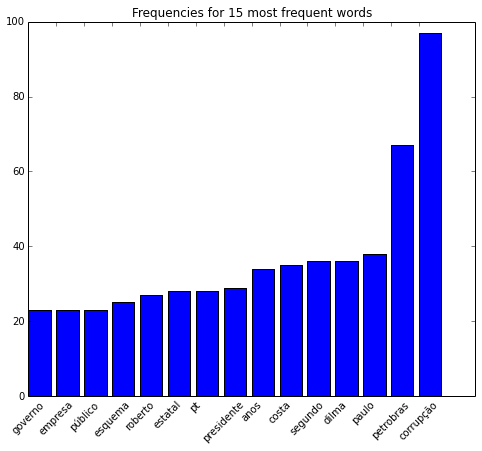

In [175]:
number_words=15      
w_items = freq_words.items()
w_items.sort(key = lambda wc: wc[1])
print 'Number of unique words:',len(w_items)
#print('{} least frequent words:').format(number_words)
#print_vk(w_items[:10])
#print('{} most frequent words:').format(number_words)
print_vk(w_items[:-10:-1])
plot_word_histogram(w_items, number_words,'Frequencies for {} most frequent words'.format(number_words));

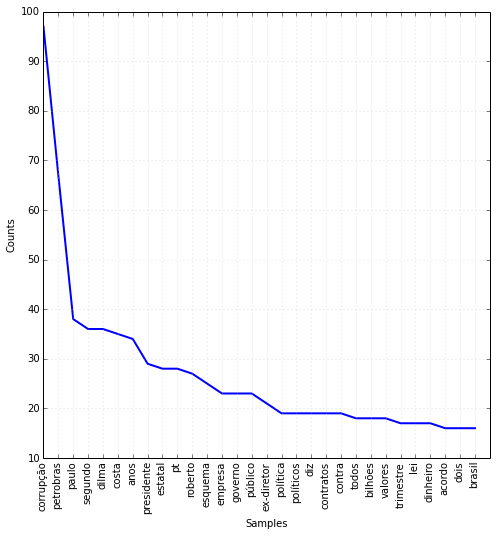

In [166]:
fd_words = nltk.FreqDist(freq_words)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8)) 
fd_words.plot(30)

E a distribuição cumulativa das frequências:

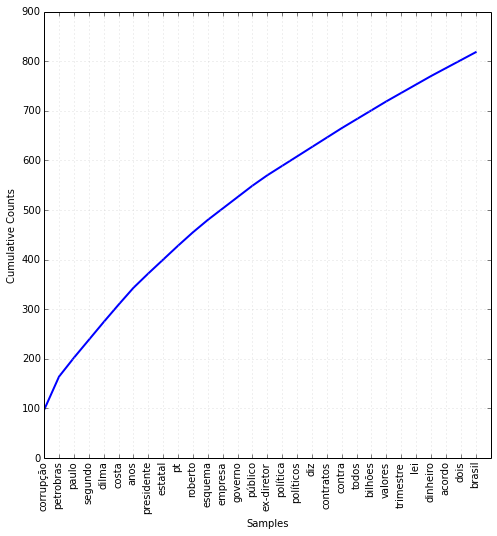

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8)) 
fd_words.plot(30, cumulative = True)

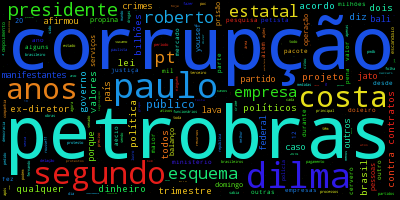

In [168]:
count = np.array(freq_words.values())
words = np.array(freq_words.keys())
count = count.astype(int)
make_wordcloud(words, count, 'test.png')
Image(filename='test.png', width=640, height=480)

Vamos agora construir um grafo de palavras para estudar co-ocorrências nos textos dos feeds

Abordagem e funções aproveitadas de https://github.com/ipython/talks/blob/master/notebook/text_utils.py

In [169]:
def all_pairs(items):
    """Make all unique pairs (order doesn't matter)"""
    pairs = []
    nitems = len(items)
    for i, wi in enumerate(items):
        for j in range(i+1, nitems):
            pairs.append((wi, items[j]))
    return pairs

def co_occurrences(lines, words):
    """Return histogram of co-occurrences of words in a list of lines.

    Parameters
    ----------
    lines : list
      A list of strings considered as 'sentences' to search for co-occurrences.

    words : list
      A list of words from which all unordered pairs will be constructed and
      searched for co-occurrences.
    """
    wpairs = all_pairs(words)

    # Now build histogram of co-occurrences
    co_occur = {}
    for w1, w2 in wpairs:
        rx = re.compile('%s .*%s|%s .*%s' % (w1, w2, w2, w1))
        co_occur[w1, w2] = sum([1 for line in lines if rx.search(line)])

    return co_occur

def co_occurrences_graph(word_hist, co_occur, cutoff=0):
    """Convert a word histogram with co-occurrences to a weighted graph.
    Edges are only added if the count is above cutoff.
    """
    g = nx.Graph()
    for word, count in word_hist:
        g.add_node(word, count=count)
    for (w1, w2), count in co_occur.iteritems():
        if count<=cutoff:
            continue
        g.add_edge(w1, w2, weight=count)
    return g

In [180]:
list_raw_texts

[u'RIO DE JANEIRO - J\xe1 tivemos a sa\xfava como inimiga preferencial. Ela n\xe3o acabou com o Brasil, mas fez o que p\xf4de. Policarpo Quaresma e Macuna\xedma deixaram duas advert\xeancias hist\xf3ricas: derrotou o personagem de Lima Barreto que acreditava no Brasil e serviu de mantra para M\xe1rio de Andrade lan\xe7ar seu famoso an\xe1tema, "pouca sa\xfade e muita sa\xfava os males do Brasil s\xe3o".\n\nA sa\xfava foi para o banco dos reservas (pode entrar em campo a qualquer hora), mas a titular da posi\xe7\xe3o, muito mais mal\xe9fica do que a sa\xfava, \xe9 a corrup\xe7\xe3o que faz parte do nosso DNA. Basta consultar jornais, revistas, TVs e internet para identificarmos o micr\xf3bio que pode nos levar a um estado terminal.\n\nFalo em DNA porque o v\xedrus j\xe1 se entranhou no organismo da na\xe7\xe3o. Para simplificar: se n\xe3o fossem as propinas ainda estar\xedamos nus, arco e flecha na m\xe3o, esperando as caravelas de Cabral, n\xe3o o governador, mas o almirante.\n\nUm r\x

In [172]:
n_nodes = 5
popular = w_items[-n_nodes:]
pop_words = [wc[0] for wc in popular]
co_occur = co_occurrences(list_raw_texts, pop_words)
wgraph = co_occurrences_graph(popular, co_occur, cutoff=1)
wgraph = list(nx.connected_component_subgraphs(wgraph))[0]
centrality = nx.eigenvector_centrality_numpy(wgraph)
c = centrality.items()
c.sort(key=lambda x:x[1], reverse=True)
print '\nGraph centrality'
for node, cent in c:
    print "%15s: %.3g" % (node, float(cent))

ValueError: k=1 must be between 1 and ndim(A)-1=0

In [ ]:
rad0 = 0.2
def rescale_arr(arr, amin, amax):
    """Rescale an array to a new range.
    Return a new array whose range of values is (amin, amax).
    Parameters
    ----------
    arr : array-like
    amin : float
      new minimum value
    amax : float
      new maximum value

    Examples
    --------
    >>> a = np.arange(5)
    >>> rescale_arr(a,3,6)
    array([ 3.  ,  3.75,  4.5 ,  5.25,  6.  ])
    """
    # old bounds
    m = arr.min()
    M = arr.max()
    # scale/offset
    s = float(amax-amin)/(M-m)
    d = amin - s*m

    # Apply clip before returning to cut off possible overflows outside the
    # intended range due to roundoff error, so that we can absolutely guarantee
    # that on output, there are no values > amax or < amin.
    return np.clip(s*arr+d,amin,amax)

def plot_graph(wgraph, pos=None, fig=None, title=None):
    """Conveniently summarize graph visually"""

    # config parameters
    edge_min_width= 3
    edge_max_width= 12
    label_font = 16
    node_font = 18
    node_alpha = 0.4
    edge_alpha = 0.55
    edge_cmap = plt.cm.Spectral

    # Create figure
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.add_subplot(111)
    fig.subplots_adjust(0,0,1)

    # Plot nodes with size according to count
    sizes = []
    degrees = []
    for n, d in wgraph.nodes_iter(data=True):
        sizes.append(d['count'])
        degrees.append(wgraph.degree(n))

    sizes = rescale_arr(np.array(sizes, dtype=float), 100, 1000)

    # Compute layout and label edges according to weight
    pos = nx.spring_layout(wgraph) if pos is None else pos
    labels = {}
    width = []
    for n1, n2, d in wgraph.edges_iter(data=True):
        w = d['weight']
        labels[n1, n2] = w
        width.append(w)

    width = rescale_arr(np.array(width, dtype=float), edge_min_width, 
                        edge_max_width)

    # Draw
    nx.draw_networkx_nodes(wgraph, pos, node_size=sizes, node_color=degrees,
                           alpha=node_alpha)
    nx.draw_networkx_edges(wgraph, pos, width=width, edge_color=width,
                           edge_cmap=edge_cmap, alpha=edge_alpha)
    nx.draw_networkx_edge_labels(wgraph, pos, edge_labels=labels, 
                                 font_size=label_font)
    nx.draw_networkx_labels(wgraph, pos, font_size=node_font, font_weight='bold')
    if title is not None:
        ax.set_title(title, fontsize=label_font)
    ax.set_xticks([])
    ax.set_yticks([])

    # Mark centrality axes
    kw = dict(color='k', linestyle='-')
    cross = [ax.axhline(0, **kw), ax.axvline(rad0, **kw)]
    [ l.set_zorder(0) for l in cross]
    
def centrality_layout(wgraph, centrality):
    """Compute a layout based on centrality.
    """
    # Create a list of centralities, sorted by centrality value
    cent = sorted(centrality.items(), key=lambda x:float(x[1]), reverse=True)
    nodes = [c[0] for c in cent]
    cent  = np.array([float(c[1]) for c in cent])
    rad = (cent - cent[0])/(cent[-1]-cent[0])
    rad = rescale_arr(rad, rad0, 1)
    angles = np.linspace(0, 2*np.pi, len(centrality))
    layout = {}
    for n, node in enumerate(nodes):
        r = rad[n]
        th = angles[n]
        layout[node] = r*np.cos(th), r*np.sin(th)
    return layout

In [ ]:
print "Graph visualization for query:"
plot_graph(wgraph, centrality_layout(wgraph, centrality), 
           plt.figure(figsize=(12,12)), 
           title = u'Centrality and term co-occurrence graph, q="{}"'.format(query))

Para entender os contextos, uma análise de concordâncias
(palavras associadas à expressão escolhida, posicionadas na mesma sentença):

In [ ]:
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(raw_texts) # texto com stopwords
#tokens = tknzr.tokenize(cleaned_texts) # texto sem stopwords
nltk_text = nltk.Text(tokens)
nltk_text.concordance(query, width=128, lines=10)

Palavras que ocorrem em contextos similares (associadas às mesmas palavras que a consulta):

In [ ]:
nltk_text.similar(query)

As colocações (que não são co-ocorrências) nos informam sobre as palavras (quaisquer, não necessariamente ligadas à consulta) que ocorrem conjuntamente (bigramas frequentes):
http://en.wikipedia.org/wiki/Collocation
http://en.wikipedia.org/wiki/Co-occurrence

In [ ]:
nltk_text.collocations(num=100, window_size=2)

Collocations are expressions of multiple words which commonly co-occur.

Below we are using Pointwise Mutual Information.

http://en.wikipedia.org/wiki/Pointwise_mutual_information

In [ ]:
max_items = 50
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print a, b

In [ ]:
max_items = 50
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print a, b, c

In [ ]:
for a, b in (finder2.above_score(bigram_measures.raw_freq,1.0 / len(list(nltk.bigrams(tokens))))):
        print a, b

In [ ]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq,1.0 / len(list(nltk.trigrams(tokens)))):
        print a, b, c

In [ ]:
from nltk.util import ngrams
n = 4
xgrams = ngrams(tokens, n)
xgrams_counter = Counter(xgrams)
df_ngrams = pd.DataFrame(xgrams_counter.items(), columns = [u'n-gramas',u'Frequência'])
df_ngrams = df_ngrams.sort_index(by=u'Frequência', ascending=False)
df_ngrams.set_index([u'n-gramas'], inplace=True)
df_ngrams[0:40]

In [ ]:
nltk_text.dispersion_plot([u'fgv', 
                      u'ipea', 
                      u'ibge',
                      u'aécio',
                      u'dilma',
                      u'lula',
                      u'renda',
                      u'cps-fgv',
                      ])

As funções a seguir permitem extrair as frases mais significativas do texto (sumarização automática)

In [ ]:
def score_sentences(sentences, important_words):
    # Approach taken from "The Automatic Creation of Literature Abstracts" by H.P. Luhn
    CLUSTER_THRESHOLD = 5  # Distance between words to consider
    scores = []
    sentence_idx = -1
    #for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:
    punktw2 = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    for s in [punktw2.tokenize(s) for s in sentences]:    
        sentence_idx += 1
        word_idx = []
        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence
                word_idx.append(s.index(w))
            except ValueError, e: # w not in this particular sentence
                pass
        word_idx.sort()
        # It is possible that some sentences may not contain any important words at all
        if len(word_idx)== 0: continue
        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words
        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_THRESHOLD:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)
        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence
        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster
            if score > max_cluster_score:
                max_cluster_score = score
        scores.append((sentence_idx, score))
    return scores

In [ ]:
def summarize(txt):
    TOP_SENTENCES = 10  # Number of sentences to choose on "top n"
    N = 100  # Number of words to consider
    #sentences = [s for s in nltk.tokenize.sent_tokenize(txt)]
    punkts = nltk.tokenize.PunktSentenceTokenizer() #trocando pelo punkt (melhor?)
    punktw = nltk.tokenize.WordPunctTokenizer() #trocando pelo punkt (melhor?)
    sentences = [s for s in punkts.tokenize(txt)]
    normalized_sentences = [s.lower() for s in sentences]
    words = [w.lower() for sentence in normalized_sentences for w in punktw.tokenize(sentence)]
    fdist = nltk.FreqDist(words)
    top_n_words = [w[0] for w in fdist.items() if w[0] not in ignore_words][:N]
    scored_sentences = score_sentences(normalized_sentences, top_n_words)
    # First approach:
    # Filter out non-significant sentences by using the average score plus a
    # fraction of the std dev as a filter
    avg = np.mean([s[1] for s in scored_sentences])
    std = np.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > avg + 0.5 * std]
    # Second Approach: 
    # Return only the top N ranked sentences
    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])
    # Decorate the post object with summaries
    return dict(top_n_summary=[sentences[idx] for (idx, score) in top_n_scored],
                mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored])

In [ ]:
sumarios = summarize(raw_texts)
sumarios['top_n_summary'] = set(sumarios['top_n_summary'])
sumarios['mean_scored_summary'] = set(sumarios['mean_scored_summary'])

print(u'frases mais importantes(1):\n')
for s in sumarios['top_n_summary']:
    print(u'{}\n'.format(s))

In [ ]:
print(u'\nfrases mais importantes(2):\n')
for s in sumarios['mean_scored_summary']:
    print(u'{}\n'.format(s))

Extração de palavras relevantes usando TF-IDf  
http://radimrehurek.com/gensim/models/tfidfmodel.html  
http://radimrehurek.com/gensim/tutorial.html  
http://radimrehurek.com/gensim/tut2.html  

In [ ]:
tokens_once = [key for key in freq_words.keys() if freq_words[key]==1]
texts = [[word.strip(string.punctuation) for word in document.lower().split() if word not in ignore_words]
         for document in list_raw_texts]
texts = [[word for word in text if word not in tokens_once and len(word) > 1] for text in texts]
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
x = 1
for doc in corpus_tfidf:
    print(u'\nRelevant Words in Document {}:\n'.format(x))
    relev = 0
    top_w = ''
    x+=1
    for w_in_dic, tfidf_w in doc:
        if tfidf_w > relev:
            top_w = w_in_dic
            relev = tfidf_w
    if top_w != '' and relev > 0:
        print('{}\t{}'.format(dictionary[top_w], relev)) #Rever questão do UTF-8
    else:
        print('Nothing relevant')